# Исследование надежности заемщиков.

Кредитному отделу банка нужно оценить риски: сможет ли заемщик вернуть кредит вовремя или нет. Имея статистику о платежеспособности клиентов, проведём исследование, чтобы модели было проще подбирать важные признаки для решения задачи, - посмотрим, как разная информация о заёмщике влияет на факт погашения кредита в срок.

**Цель исследования** - проверить гипотезы:

 * Семейное положение клиента влияет на факт погашения кредита в срок. 
 * Количество детей клиента влияет на факт погашения кредита в срок. 
 * Чем выше уровень дохода, тем меньше вероятность просрочки по кредиту
 * Есть корреляция между целью получения кредита и фактом его погашения в срок

**Ход исследования**

 1. Обзор данных.
 2. Предобработка данных.
 3. Проверка гипотез.

## Шаг 1. Обзор данных

Составим первое представление о данных с помощью средств pandas

In [1]:
# импорт библиотеки pandas
import pandas as pd

In [2]:
# чтение файла с данными и сохранение в df
df = pd.read_csv('/datasets/data.csv')

Посмотрим первые 10 строк таблицы

In [3]:
# получение первых 10 строк таблицы df
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Уже по первым 10 строкам видно, что в данных есть проблемы:
отрицательные значения в столбце days_employed, отвечающим за трудовой стаж, разный регистр в столбце education, записанные по-разному схожие цели. 

Продолжим изучать данные. Теперь посмотрим общую информацию о таблице

In [4]:
# получение общей информации о данных в таблице df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Итак, в таблице есть 12 столбцов.

Опираясь на документацию к данным и общую информацию о таблице можно сказать, что

 * children — количество детей в семье - тип данных int
 * days_employed — общий трудовой стаж в днях - тип данных float
 * dob_years — возраст клиента в годах - тип данных int
 * education — уровень образования клиента - тип данных object
 * education_id — идентификатор уровня образования - тип данных int
 * family_status — семейное положение - тип данных object
 * family_status_id — идентификатор семейного положения - тип данных int
 * gender — пол клиента - тип данных object
 * income_type — тип занятости - тип данных object
 * debt — имел ли задолженность по возврату кредитов - тип данных int
 * total_income — ежемесячный доход - тип данных float
 * purpose — цель получения кредита - тип данных object

Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.

<div style="border:solid blue 2px; padding: 20px">

**Выводы**

В каждой строке таблицы - данные о клиенте. 

Предварительно можно утверждать, что данных достаточно для проверки гипотез. Однако уже из предварительного просмотра таблицы и общей информации о ней видно, что есть несколько проблем:

 * в двух столбцах встречаются пропуски в данных
 * встречаются артефакты ("странные" значения)
 * встречаются дубликаты

Чтобы двигаться дальше, нужно устранить проблемы в данных.

## Предобработка данных


Чтобы получить из данных более правильный результат, необходимо устранить проблемы, которые встречаются в данных. Заполним или удалим пропуски, приведём данные к более удобным типам, исправим аномалии, разберёмся с дубликатами и при необходимости категоризируем часть данных.

### Шаг 2.1 Заполнение пропусков (начало)

Посчитаем, сколько в таблице пропущенных значений

In [5]:
# подсчёт пропусков
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Пропуски присутствуют в двух столбцах - 'days_employed' и 'total_income'. Заметим, что пропусков одинаковое количество. Проверим гипотезу: у клиентов, у которых нет значения в столбце days_employed, присутствует пропуск и в столбце total_income. Для этого посмотрим уникальные значения столбца total_income в тех случаях, когда они удовлетворяют условию: пропуск в столбце days_employed

In [6]:
# просмотр уникальных значений в столбце total_income при условии пропуска в столбце days_employed
df[df['days_employed'].isnull()]['total_income'].unique()

array([nan])

Гипотеза подтвердилась. Действительно, пропуск в столбце days_employed соответствует пропуску в столбце total_income.

Продолжим исследование пропусков. Пропуски присутствуют в двух столбцах - 'days_employed' и 'total_income'.
В столбце 'days_employed' помимо пропусков присутствуют отрицательные значения, поэтому заполнять этот столбец пока рано.

Посмотрим, что со столбцом total_income.

Вычислим минимальное и максимальное значение и посмотрим, насколько они правдоподобны


In [7]:
#вычисление минимального значения столбца total_income
df['total_income'].min()

20667.26379327158

Минимальное значение положительное и выглядит правдоподобно

In [8]:
# вычисление максимального значения столбца total_income
df['total_income'].max()

2265604.028722744

Доход больше 2-х миллионов. Посмотрим, много ли таких значений в данных

In [9]:
# вывод таких строчек датафрейма, для которых значение в столбце total_income больше 2000000
df.loc[df['total_income'] > 2000000]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12412,0,-1477.438114,44,высшее,0,женат / замужем,0,M,компаньон,0,2.265604e+06,ремонт жилью
19606,1,-2577.664662,39,высшее,0,женат / замужем,0,M,компаньон,1,2.200852e+06,строительство недвижимости


Мы видим, что таких всего двое. 

Посмотрим, насколько сильно их доход отличается от остальных. Для этого отсортируем столбец total_income по убыванию и посмотрим на первые несколько значений

In [10]:
# вывод первых 5 значений в отсортированном по убыванию столбце total_income
df['total_income'].sort_values(ascending=False).head()

12412    2.265604e+06
19606    2.200852e+06
9169     1.726276e+06
20809    1.715018e+06
17178    1.711309e+06
Name: total_income, dtype: float64

Итак, разница между двумя людьми с самым большим доходом и остальными довольно велика

Но максимальное значение тоже выглядит правдоподобно

Значит, можно обработать пропуски в столбце total_income. 

Для начала определим, какую долю составляют пропуски в столбце. 

In [11]:
df['total_income'].isna().mean()

0.10099883855981417

Мы обнаружили, что пропуски в столбце total_income составляют больше 10 процентов, значит удалять их будет не целесообразно. Значит, их нужно заполнить какими-то значениями. Лучше всего для количественных данных подходят среднее и медиана, поскольку они не сильно исказят общую картину. Однако у нас в данных присутствуют выбросы - люди с доходом больше 2 млн, поэтому лучше воспользоваться медианой

Найдём медиану по столбцу total_income


In [12]:
# поиск медианы по столбцу total_income
median_income = df['total_income'].median()
median_income

145017.93753253992

Заменим значения nan на медиану

In [13]:
# замена значения nan на медиану
df['total_income'] = df['total_income'].fillna(median_income)

Убедимся, что пропусков не осталось

In [14]:
# подсчёт пропусков в обновлённом столбце total_income
df['total_income'].isna().sum()

0

<div style="border:solid blue 2px; padding: 20px">

**Промежуточные выводы**
    
Итак, мы обработали пропущенные значения в столбце total_income. Пропущенные значения в нём могли присутствовать в связи с тем, что клиенты могли менять работу и соответственно доход, поскольку про тех клиентов, у которых пропуски в столбце с доходом, так же неизвестен ещё и стаж. Кроме того, банку может быть просто неизвестна информация о доходе и стаже работы 

### Шаг 2.2. Изменение типов данных.

Для дальнейшего удобства заменим вещественный тип данных в столбце total_income на целочисленный

In [15]:
# замена типа данных в стобце total_income на int
df = df.astype({'total_income': 'int64'})


<div style="border:solid blue 2px; padding: 20px">

**Промежуточные выводы**
    
Итак, теперь все данные удобных для работы типов

### Шаг 2.3 Проверка данных на аномалии и исправления.

Мы видим, что в данных присутствуют значения, которые не отражают действительность и появились по какой-то ошибке. 

Устраним ошибки

Для начала выявим все аномалии

#### Начнём с количественных данных

Найдём максимальные и минимальные значения в столбцах с количественными данными, чтобы проверить данные на достоверность
Проверим все количественные данные, кроме столбца total_income, поскольку его значения мы уже проверили ранее

In [16]:
# просмотр максимальных значений в столбцах с количественными данными
df[['children',  'days_employed', 'dob_years', 'education_id', 'family_status_id', 'debt']].max()

children                20.000000
days_employed       401755.400475
dob_years               75.000000
education_id             4.000000
family_status_id         4.000000
debt                     1.000000
dtype: float64

Видны следующие аномалии:

 * 20 детей в семье. Скорее всего произошла опечатка

 * 401755 дней трудового стажа - получается, что человек работал больше 1000 лет, а люди столько не живут. Возможно, в каких-то ячейках время указано не в днях, а в часах




Посмотрим на минимальные значения

In [17]:
# просмотр минимальных значений в столбцах с количественными данными
df[['children',  'days_employed', 'dob_years', 'education_id', 'family_status_id', 'debt']].min()

children               -1.000000
days_employed      -18388.949901
dob_years               0.000000
education_id            0.000000
family_status_id        0.000000
debt                    0.000000
dtype: float64

Видны следующие аномалии:

 * -1 ребёнок в семье. Скорее всего опечатка
 * возраст клиента 0 лет
 * Отрицательное значение трудового стажа


Итак, в количественных данных нужно обработать столбцы children, dob_years и days_employed

##### Столбец children

Посмотрим, какие вообще значения есть в данном столбце

In [18]:
# просмотр уникальных значений столбца children
df['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

Мы видим, что из аномальных значений встретились значения -1 и 20. Посмотрим, сколько раз встречается каждое из этих значений.

In [19]:
# длина датафрейма, состоящего из строк, в которых значение в колонке children равно -1
len(df[df['children'] == -1])

47

In [20]:
# длина датафрейма, состоящего из строк, в которых значение в колонке children равно 20
len(df[df['children'] == 20])

76

Посмотрим, какую часть датафрейма составляют эти данные

In [21]:
# вычисление соотношения длины датафрейма с ячейками со значением -1 в столбце children к длине столбца children 
len(df[df['children'] == -1])/len(df['children'])

0.002183507549361208

In [22]:
# вычисление соотношения длины датафрейма с ячейками со значением 20 в столбце children к длине столбца children 
len(df[df['children'] == 20])/len(df['children'])

0.0035307781649245064

Мы видим, что данные со значением -1 составляют меньше, чем четверть процента от всего датасета. Поскольку значение -1 может означать как 1 ребёнка, так и использоваться в качестве замены пустого значения, а всего разнообразных значений не так много, то лучше удалить эти данные.

Аналогично 20 может означать и то, что человек мог в спешке не поставить запятую - 2,0 и выступать в качестве замены для любого большого значения

Сохраним в датафрейм строки, для которых ячейка в столбце children принимает неотрицательное значение меньшие 20.

In [23]:
# Сохранение в датафрейме строк, для которых ячейка в столбце children принимает неотрицательное значение меньшие 20.
df = df[df['children'] >= 0]
df = df[df['children'] < 20]

Проверим, что теперь действительно в датафрейме нет аномальных значений в столбце children

In [24]:
# просмотр значений в столбце children
df['children'].value_counts()

0    14149
1     4818
2     2055
3      330
4       41
5        9
Name: children, dtype: int64

##### Столбец dob_years

В столбце dob_years была проблема с тем, что встречался возраст 0 лет. Посмотрим, сколько всего таких значений

In [25]:
# длина датафрейма, состоящего из строк, в которых значение в колонке dob_years равно 0
len(df[df['dob_years'] == 0])

100

Мы видим, что у 100 человек указан возраст 0 лет. Это может быть связано с тем, что при заполнении данных был известен возраст не каждого человека и 0 заполнили пустые значения.

Поскольку для дальнейшего исследования возраст нам будет не нужен, не будем удалять нулевые значения

##### Столбец days_employed

Значения в этом столбце почти у всех отрицательные. Гипотеза: это может связано с типом занятости.
Посмотрим, какие типы занятости у клиентов, у которых отрицательное значение трудового стажа и какие у тех, у которых положительное

In [26]:
# просмотр значений столба income_type для тех строк, для которых значение в days_employed отрицательное
df[df['days_employed'] < 0]['income_type'].unique()

array(['сотрудник', 'компаньон', 'госслужащий', 'студент',
       'предприниматель', 'в декрете'], dtype=object)

In [27]:
# просмотр значений столба income_type для тех строк, для которых значение в days_employed положительное
df[df['days_employed'] > 0]['income_type'].unique()

array(['пенсионер', 'безработный'], dtype=object)

Итак, мы видим, что у нас образовалось два непересекающихся множества. Значит, гипотеза подтвердилась. Действительно, для одних профессий трудовой стаж выражен отрицательным числом, а для других положительным. 

Отрицательные значения скорее всего просто ошибка ввода данных. Это может быть связано с тем, что для разных типов  занятости данные вбивали разные люди и кто-то мог вбивать тире, которое считывалось, как минус. Обработаем аномальные значения этого столбца.

Для начала приведём все значения в этом столбце к неотрицательным

In [28]:
# замена всех значений столбца days_employed на положительные
df['days_employed'] = df['days_employed'].apply(abs)

Проверим, что в столбце не осталось отрицатльных значений

In [29]:
# вывод длины датафрейма, для которого в столбце days_employed встречаются отрицательные значения
len(df[df['days_employed'] < 0])

0

Итак, мы убедились в том, что все значения в столбце days_employed неотрицательные.

Теперь переведём для удобства трудовой стаж в года. Так будет проще понять, где остались аномальные значения.

In [30]:
# применение лямбда функции, переводящей трудовой стаж из дней в года
df['days_employed'] = df['days_employed'].apply(lambda x: x/365)

Переименуем данный столбец, чтобы не запутаться

In [31]:
# переименование столбца
df = df.rename(columns={'days_employed': 'years_employed'})

In [32]:
# проверка результатов - перечень названий столбцов
df.columns

Index(['children', 'years_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

Столбец успешно переименован

Посмотрим максимальное значение трудового стажа (в годах) для каждого типа занятости

In [33]:
# группировка датафрейма по столбцу income_type и просмотр соответствующих максимальных значений столбца years_employed 
df.groupby('income_type')['years_employed'].max()

income_type
безработный        1083.021476
в декрете             9.032219
госслужащий          41.624746
компаньон            48.261817
пенсионер          1100.699727
предприниматель       1.426981
сотрудник            50.380685
студент               1.585621
Name: years_employed, dtype: float64

Мы видим, что аномальные значения остались у пенсионеров и безработных. Возможно, для них время указано в часах. Приведём к общему значению. Для этого создадим специальную функцию, переводящую из часов в года.

In [34]:
# создание функции from_hours_to_years с параметром row
def from_hours_to_years(row):
    '''
    Функция получает на вход строку из датафрейма. 
    Затем она выделяет в отдельные переменные значения этой строки в столбцах income_type и years_employed.
    И если значение переменной income_type соответствует одной из двух категорий: безработный или пенсионер,
    функция делит значение переменной days_employed на 24.
    Возвращает функция значение переменной years_employed
    '''
    income_type = row['income_type']
    years_employed = row['years_employed']
    if income_type == 'безработный' or income_type == 'пенсионер':
        years_employed /= 24
    return years_employed

In [35]:
# применение функции from_hours_to_years
df['years_employed'] = df.apply(from_hours_to_years, axis=1)

Посмотрим, что из этого вышло. Посмотрим на самые маленькие значения

In [36]:
# группировка датафрейма по столбцу income_type и просмотр соответствующих минимальных значений столбца years_employed 
df.groupby('income_type')['years_employed'].min()

income_type
безработный        38.530190
в декрете           9.032219
госслужащий         0.109463
компаньон           0.082727
пенсионер          37.526110
предприниматель     1.426981
сотрудник           0.066141
студент             1.585621
Name: years_employed, dtype: float64

И на самые большие

In [37]:
# группировка датафрейма по столбцу income_type и просмотр соответствующих максимальных значений столбца years_employed 
df.groupby('income_type')['years_employed'].max()

income_type
безработный        45.125895
в декрете           9.032219
госслужащий        41.624746
компаньон          48.261817
пенсионер          45.862489
предприниматель     1.426981
сотрудник          50.380685
студент             1.585621
Name: years_employed, dtype: float64

Да, то, что пенсионер за всю жизнь работал меньше года - это странно, но более правдоподобно, чем то, что он работал 1000 лет. Поэтому оставим этот столбец таким. Тем более, что для дальнейшего исследования эти данные не будут важны.

<div style="border:solid blue 2px; padding: 20px">

**Промежуточные выводы**
    
Итого, в количественных данных исправлены следующие выбросы
 * Удалены аномальные значения столбца children
 * Рассмотрены проблемы нулевого возраста в столбце dob_years
 * Переименован столбец days_employed в years_employed
 * В столбце years_employed данные приведены в года
 * Отрицательные значения столбца years_employed заменены положительными

#### Посмотрим на категориальные количественные данные

Убедимся, что в столбцах, значения в которых должны принадлежать одному значению из списка, нет выбросов

##### Столбец debt

Значения в этом столбце должны быть 0 или 1

In [38]:
# вывод уникальных значений столбца debt
df['debt'].unique()

array([0, 1])

Да, так и есть

##### Столбец education_id 

Значения в этом столбце должны быть 0, 1, 2, 3, 4

In [39]:
# вывод уникальных значений столбца education_id
df['education_id'].unique()

array([0, 1, 2, 3, 4])

Да, так и есть

##### Столбец family_status_id  

Значения в этом столбце должны быть 0, 1, 2, 3, 4

In [40]:
# вывод уникальных значений столбца family_status_id
df['family_status_id'].unique() 

array([0, 1, 2, 3, 4])

Да, так и есть

<div style="border:solid blue 2px; padding: 20px">

**Промежуточные выводы**
    
Итого, в категориальных количественных данных проблем не обнаружено

### Шаг 2.4 Заполнение пропусков (продолжение)


Теперь можно разобраться с пропусками в столбце years_employed. Посмотрим, какую долю составляют пропуски

In [41]:
# соотношение количества пропусков к общему количеству ячеек в столбце years_employed
df['years_employed'].isna().sum()/len(df['years_employed'])

0.10101859639286048

10 процентов - довольно много. Значит, лучше не удалять эти данные. Выше было объяснено, почему лучше заполнять пропуски в количественных данных медианой. Заполним их и в этом столбце.

In [42]:
# поиск медианы по столбцу years_employed
median_years_employed = df['years_employed'].median()

In [43]:
# заполнение пропусков медианным значением
df['years_employed'] = df['years_employed'].fillna(median_years_employed)

Проверим, что пропусков не осталось

In [44]:
# подсчёт количества пропусков в столбце years_employed
df['years_employed'].isna().sum()

0

<div style="border:solid blue 2px; padding: 20px">

**Выводы**
    
Пропуски в столбце years_employed заполнены медианным значением по столбцу.

В итоге, в датафрейме не осталось пропусков

### Шаг 2.5 Проверка данных на аномалии и исправления (продолжение)

Разберёмся теперь с нечисловыми столбцами
Посмотрим, какие значения присутствуют в них.

In [45]:
# просмотр уникальных значений в столбце education
df['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

In [46]:
# просмотр уникальных значений в столбце family_status
df['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

In [47]:
# просмотр уникальных значений в столбце gender
df['gender'].unique()

array(['F', 'M', 'XNA'], dtype=object)

In [48]:
# просмотр уникальных значений в столбце income_type
df['income_type'].unique()

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

In [49]:
# просмотр уникальных значений в столбце purpose
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

<div style="border:solid blue 2px; padding: 20px">

**Промежуточные выводы**
    

В не количественных ячейках удалось заметить аномалию в столбце gender.
    
А так же дубликаты в столбцах education и purpose

#### Столбец gendre

Ещё раз посмотрим на уникальные значения в этом столбце

In [50]:
# просмотр уникальных значений в столбце gender
df['gender'].unique()

array(['F', 'M', 'XNA'], dtype=object)

Мы видим, что встречается странное значение XNA.

Посмотрим, сколько раз встречается странное значение XNA

In [51]:
# длина датафрейма, для которого значение в столбце gender равно XNA
len(df[df['gender'] == 'XNA'])

1

Мы видим, что такое аномальное значение встречается всего 1 раз. Это может быть связано с тем, что произошла какая-то ошибка, данные затерялись. Поскольку для дальнейшего исследования данные из этого столбца нам не важны, можно оставить его без изменений.

<div style="border:solid blue 2px; padding: 20px">

**Промежуточные выводы**
    
Нам удалось разобраться с аномальным значением в столбце gender. Обрабатывать это значение мы не стали, поскольку в ходе дальнейшего исследования значения из этого столбца нам не пригодятся

### Шаг 2.6. Удаление дубликатов.

Посмотрим, есть ли в данных явные дубликаты

In [52]:
# подсчёт количества явных дубликатов
df.duplicated().sum()

54

Удалим явные дубликаты

In [53]:
# удаление явных дубликатов
df = df.drop_duplicates().reset_index(drop=True)

Убедимся, что явных дубликатов не осталось

In [54]:
# подсчёт количества явных дубликатов
df.duplicated().sum()

0

Теперь разберёмся с неявными дубликатами. Они встречаются в столбцах education и purpose 

Для того, чтобы в столбце education избавиться от неявных дубликатов, достаточно привести все значения в нижний регистр. Сделаем это при помощи функции str.lower()

In [55]:
# перевод всех значений в столбце education в нижний регистр
df['education'] = df['education'].str.lower()

Проверим, что неявных дубликатов больше не осталось

In [56]:
# вывод уникальных значений столбца education
df['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

<div style="border:solid blue 2px; padding: 20px">

**Промежуточные выводы**
    
Итак, у нас больше нет дубликатов в столбце education. 
    
От дубликатов в столбце purpose избавимся позднее, когда классифицируем цели

### Шаг 2.7. Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

Для удобства работы с таблицей уберём из неё столбцы education и family_status, поскольку для них есть столбцы education_id и family_status_id 

In [57]:
# выделение в отдельный датафрейм столбцов education и education_id
education_dict = df[['education', 'education_id']]

In [58]:
# удаление дубликатов
education_dict = education_dict.drop_duplicates().reset_index(drop=True)

In [59]:
# просмотр получившегося датафрейма
education_dict

,education,education_id
0,высшее,0
1,среднее,1
2,неоконченное высшее,2
3,начальное,3
4,ученая степень,4


Проделаем аналогичную работу со столбцами family_status и family_status_id

In [60]:
# выделение в отдельный датафрейм столбцов family_status и family_status_id
family_status_dict = df[['family_status', 'family_status_id']]

In [61]:
# удаление дубликатов
family_status_dict = family_status_dict.drop_duplicates().reset_index(drop=True)

In [62]:
# просмотр получившегося датафрейма
family_status_dict

,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,Не женат / не замужем,4


Теперь удалим из основного датафрейма лишнюю информацию

In [63]:
# замена исходного датафрейма новым, в котором нет столбцов education и family_status, а есть только соотвествующие им идентификаторы
df = df[['children', 'years_employed', 'dob_years', 'education_id', 'family_status_id', 'gender', 'income_type', 'debt', 'total_income', 'purpose']]

<div style="border:solid blue 2px; padding: 20px">

**Выводы**
    
Итого, созданы два словаря - для education и для family_status. По ним можно найти, что значит каждый id

### Шаг 2.8. Категоризация дохода.

Сгруппируем доход по категориям. Напишем специальную функцию и создадим столбец total_income_category, в который поместим значения этой функции, применённой к столбцу total_income

In [64]:
def total_income_group(total_income):
    """
    Функция принимает на вход значение total_income - число.
    Затем в зависимости от величины этого числа возвращает одну из 5 категорий.
    """
    if total_income <= 30000:
        return 'E'
    elif total_income <= 50000:
        return 'D'
    elif total_income <= 200000:
        return 'C'
    elif total_income <= 1000000:
        return 'B'
    else:
        return 'A'

In [65]:
# применение функци total_income_group и создание нового столбца total_income_category
df['total_income_category'] = df['total_income'].apply(total_income_group)

Проверим, что новый столбец появился

In [66]:
# вывод начала датафрейма (первые 5 строк)
df.head()

,children,years_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category
0,1,23.116912,42,0,0,F,сотрудник,0,253875,покупка жилья,B
1,1,11.026860,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,C
2,0,15.406637,33,1,0,M,сотрудник,0,145885,покупка жилья,C
3,3,11.300677,32,1,0,M,сотрудник,0,267628,дополнительное образование,B
4,0,38.843159,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,C


<div style="border:solid blue 2px; padding: 20px">

**Выводы**
    
Итого, 
 * создан дополнительный столбец, в который помещено значение категории дохода
 * написана функция, вычисляющая категорию дохода
    

### Шаг 2.9. Категоризация целей кредита.

Разделим цели на категории. Посмотрим, какие цели вообще есть

In [67]:
# вывод уникальных значений столбца purpose
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Мы видим, что все цели так или иначе связаны с 4 вещами: автомобиль, недвижимость, свадьба, образование.

Напишем функцию, которая разделит все значения по этим категориям

In [68]:
def purpose_group(purpose):
    """
    Функция принимает на вход переменную, в которой написана цель.
    Далее в зависимости от того, с чем связана эта цель, функция возвращает одну из 4 категорий.
    """
    if 'авто' in purpose:
        return 'операции с автомобилем'
    elif 'недвижим' in purpose or 'жиль' in purpose:
        return 'операции с недвижимостью'
    elif 'свадьб' in purpose:
        return 'проведение свадьбы'
    else:
        return 'получение образования'

In [69]:
# создание нового столбца purpose_category и применение функции purpose_group
df['purpose_category'] = df['purpose'].apply(purpose_group)

Проверим, что столбец появился

In [70]:
# вывод первых пяти строк датафрейма
df.head()

,children,years_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category,purpose_category
0,1,23.116912,42,0,0,F,сотрудник,0,253875,покупка жилья,B,операции с недвижимостью
1,1,11.026860,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,C,операции с автомобилем
2,0,15.406637,33,1,0,M,сотрудник,0,145885,покупка жилья,C,операции с недвижимостью
3,3,11.300677,32,1,0,M,сотрудник,0,267628,дополнительное образование,B,получение образования
4,0,38.843159,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,C,проведение свадьбы


<div style="border:solid blue 2px; padding: 20px">

**Выводы**
    
Итого, 
 * все цели кредита разделены на 4 категории - написана функция, присвающая каждому значению категорию
 * создан дополнительный столбец, в который помещено значение категории целей кредита


<div style="border:solid blue 2px; padding: 20px">

**Выводы по предобработке**

В ходе предобработки данных устранены следующие недочёты

 * заполнены пропуска для значений трудового стажа и ежемесячного дохода
 * тип данных для дохода изменён на целочисленный
 * удалены строки с аномальными значениями количества детей (-1 и 20)
 * выявлена проблема с нулевым возрастом и с некорректным полом
 * стаж переведён из дней и часов в года
 * удалены явные дубликаты
 * обработаны неявные дубликаты в слобце с образованием
 * категоризирован доход
 * категоризированы цели
 * составлены словари для образования и семейного положения, поскольку для них уже есть идентификаторы. Лишние столбцы удалены


### Ответы на вопросы.

##### Вопрос 1:

**Есть ли зависимость между количеством детей и возвратом кредита в срок?**


Посмотрим, исходя из каких данных мы можем сделать выводы - сколько у нас представителей каждой группы по столбцу children

In [71]:
# просмотр количества значений каждой категории столбца children
df['children'].value_counts()

0    14107
1     4809
2     2052
3      330
4       41
5        9
Name: children, dtype: int64

Сделаем сводную таблицу, в которой посмотрим, как часто клиенты с разным количеством детей имеют просрочки

Применим функцию mean() поскольку в каждой группе с кол-вом детей разное количество людей. 

In [72]:
# создание сводной таблицы для столбцов children и debt
df_children_pivot = df.pivot_table(index='children', values='debt', aggfunc='mean')

In [73]:
# вывод сводной таблицы
df_children_pivot

,debt
children,
0,0.075353
1,0.092327
2,0.094542
3,0.081818
4,0.097561
5,0.000000


Визуализируем получившейся результат

In [75]:
# импортируем библиотеку seaborn
import seaborn as sns

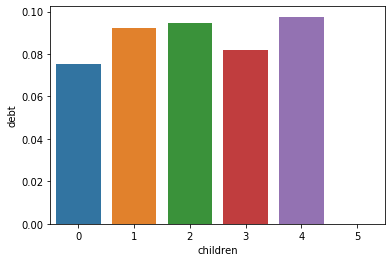

In [77]:
# построим столбчатую диаграмму, на которой по горизонтали отложены значения количества детей в семье, 
# а по вертикали значение просрочки в среднем
sns.barplot(x=df_children_pivot.index, y=df_children_pivot['debt'])

##### Вывод 1:

Мы видим, что совсем нет просрочек у тех, у кого 5 детей. Однако, представителей этой группы совсем мало, поэтому на их основании нельзя точно сделать вывод о корреляции. Но можно отместить, что клиенты не имеющие детей в среднем немного реже не выплачивают кредит в срок, в отличие от клиентов, имеющих детей. Это объясняется тем, что у них пропадает часть расходов на обеспечения ребёнка

##### Вопрос 2:

**Есть ли зависимость между семейным положением и возвратом кредита в срок?**

Посмотрим, исходя из каких данных мы можем сделать выводы - сколько у нас представителей каждой группы по столбцу family_status_id

In [79]:
# просмотр количества значений каждой категории столбца family_status_id
df['family_status_id'].value_counts()

0    12266
1     4146
4     2796
3     1189
2      951
Name: family_status_id, dtype: int64

In [80]:
# создание сводной таблицы для столбцов family_status_id и debt
df_family_status_pivot = df.pivot_table(index='family_status_id', values='debt', aggfunc='mean')

In [81]:
# вывод сводной таблицы
df_family_status_pivot

,debt
family_status_id,
0,0.075575
1,0.092861
2,0.066246
3,0.070648
4,0.097639


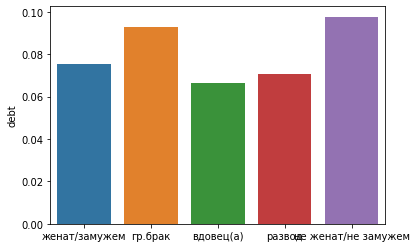

In [82]:
# построим столбчатую диаграмму, на которой по горизонтали отложены значения семейного положения
# а по вертикали значение просрочки в среднем
sns.barplot(x=["женат/замужем", "гр.брак", "вдовец(а)", "развод", "не женат/не замужем"], y=df_family_status_pivot['debt'])

##### Вывод 2:

Явной корреляции опять же не наблюдается, но мы можем видеть, что клиенты не женатые/не находящиеся замужем, а также те, кто состоит в гражданском браке, в среднем чуть чаще остальных не выплачивают кредит в срок. Возможно, это связно с возрастом и с количеством амбиций.

##### Вопрос 3:

**Есть ли зависимость между уровнем дохода и возвратом кредита в срок?**

In [83]:
# просмотр количества значений каждой категории столбца total_income_category
df['total_income_category'].value_counts()

C    15939
B     5013
D      349
A       25
E       22
Name: total_income_category, dtype: int64

In [84]:
# создание сводной таблицы для столбцов total_income_category и debt
df_total_income_pivot = df.pivot_table(index='total_income_category', values='debt', aggfunc='mean')

In [85]:
# вывод сводной таблицы
df_total_income_pivot

,debt
total_income_category,
A,0.080000
B,0.070616
C,0.084886
D,0.060172
E,0.090909


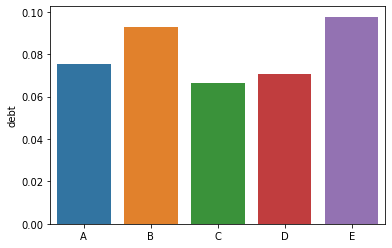

In [86]:
# построим столбчатую диаграмму, на которой по горизонтали отложены значения категории дохода
# а по вертикали значение просрочки в среднем
sns.barplot(x=['A', 'B', 'C', 'D', 'E'], y=df_family_status_pivot['debt'])

##### Вывод 3:

Мы видим, что клиенты, относящиеся к категории E т.е. имеющие доход не больше 30000 чаще остальных имеют просрочки по кредиту. Это можно объяснить тем, что представители данной категории не всегда зарабатывают достаточно средств, чтобы погасить кредит вовремя. Однако опять же, у нас не так много представителей данной категории, поэтому не стоит делать далеко идущие выводы

##### Вопрос 4:

**Как разные цели кредита влияют на его возврат в срок?**

In [87]:
# просмотр количества значений каждой категории столбца purpose_category
df['purpose_category'].value_counts()

операции с недвижимостью    10754
операции с автомобилем       4281
получение образования        3989
проведение свадьбы           2324
Name: purpose_category, dtype: int64

In [88]:
# создание сводной таблицы для столбцов purpose_category и debt
df_purpose_pivot = df.pivot_table(index='purpose_category', values='debt', aggfunc='mean')

In [89]:
# вывод сводной таблицы
df_purpose_pivot

,debt
purpose_category,
операции с автомобилем,0.093436
операции с недвижимостью,0.072531
получение образования,0.092504
проведение свадьбы,0.078744


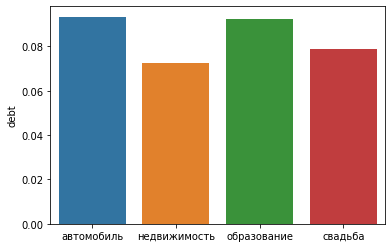

In [90]:
# построим столбчатую диаграмму, на которой по горизонтали отложены значения категории цели кредита
# а по вертикали значение просрочки в среднем
sns.barplot(x=['автомобиль', 'недвижимость', 'образование', 'свадьба'], y=df_purpose_pivot['debt'])

##### Вывод 3:
В среднем, результаты по разным категориям целей примерно одинаковые. После покупки автомобиля люди начинают меньше денег и времени тратить на дорогу, поэтому им легче закрыть кредит, после покупки недвижимости не приходится тратить деньги на съём квартиры, после получения образования клиенты могут найти новую работу, а после свадьбы могут выплачивать кредит уже вдвоём. Поэтому, в целом, разные цели кредита не так сильно влияют на факт его погашения в срок.

## Общий вывод:

В результате проверки гипотез было уставлено, что
 * клиенты не имеющие детей чаще выплачивают кредит в срок
 * клиенты с доходом не превышающем 30 тысяч реже выплачивают кредит в срок
 * явной корреляции между целями кредита и фактом его возврата в срок не найдено
 * как и явной корреляции между семейным положением и фактом возврата кредита в срок
 
Можно было бы сделать более значимые выводы, если бы было больше данных по разным категориям. 
Но уже из полученных результатов видно, что какие-то закономерности найти удаётся. 

Датасет предобработан - основные ошибки, такие как
 * наличие пропусков
 * наличие выбросов
 * неудобные типы данных
 * дубликаты
 * некатегоризированные данные
 
 
устранены,
поэтому датасет может быть использован для решения задачи кредитного скоринга